[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 256 samples in 0.001s...
[t-SNE] Computed neighbors for 256 samples in 0.021s...
[t-SNE] Computed conditional probabilities for sample 256 / 256
[t-SNE] Mean sigma: 0.246647
[t-SNE] KL divergence after 250 iterations with early exaggeration: 43.927963
[t-SNE] KL divergence after 1000 iterations: 0.334178


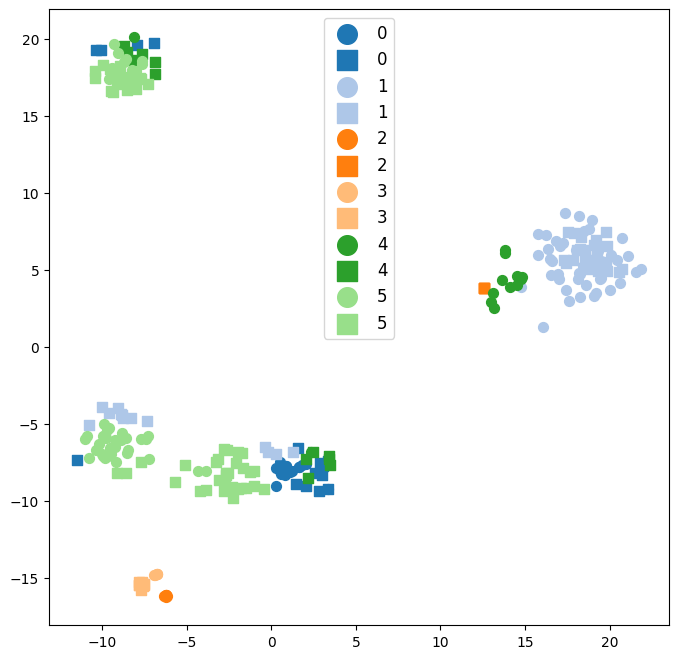

In [4]:
import pickle
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

with open('saved_dictionary2.pickle', 'rb') as f:
    loaded_dict = pickle.load(f)

src_f, src_y, trg_f, trg_y, accl = loaded_dict['1'],loaded_dict['2'],loaded_dict['3'],loaded_dict['4'],loaded_dict['acc']
#plt.plot(accl)

# we use TSNE to reduce src and trg dementality from (128,256) to (128) and match the label
tsne = TSNE(2, verbose=1)
all_f = np.vstack((src_f, trg_f))
tsne_proj = tsne.fit_transform(all_f)

# Plot those points as a scatter plot and label them based on the pred labels
cmap = matplotlib.colormaps['tab20']
fig, ax = plt.subplots(figsize=(8,8))

# WISDM has 6 classes
num_categories = 6

#Each color represents six activites of WISDM. Circles (o) denote source domain features, while squares (s) denote target domain features.
#features from both domains are distributed and clustered in the 2D space. Ideally, points with the same color (belonging to the same class) should cluster together, indicating that the features are similar.
#The overlap between circles and squares of the same color suggests that the corresponding features from the source and target domains are aligned well which is domain adaptation goal.
#x and y ranges are determined by t-SNE algorithm during the dimensionality reduction process used to spread out the data points in the 2D space to reveal the structure and relationships in the high-dimensional data.

for activity in range(num_categories):
    indices = trg_y==activity
    indices2 = src_y==activity
    tsne_src, tsne_trg = tsne_proj[0:len(src_f)],tsne_proj[len(src_f):]
    ax.scatter(tsne_src[indices2,0],tsne_src[indices2,1], s=50,marker='o',c=np.array(cmap(activity)).reshape(1,4), label = activity)
    ax.scatter(tsne_trg[indices,0],tsne_trg[indices,1],s=50,  marker='s',c=np.array(cmap(activity)).reshape(1,4), label = activity)
    
ax.legend(fontsize='large', markerscale=2)
plt.show()

<Figure size 900x600 with 0 Axes>

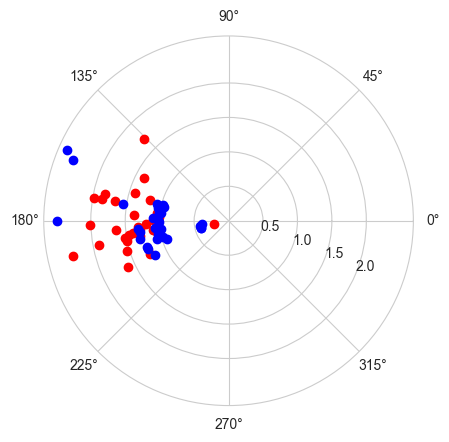

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch 
from dataloader.dataloader import data_generator
sns.set_style("whitegrid")
from configs.data_model_configs import get_dataset_class
from configs.hparams import get_hparams_class
import matplotlib.cm as cm
from models.loss import SinkhornDistance

def show_assignments(a, b, P=None, ax=None): 
    if P is not None:
        norm_P = P/P.max()
        for i in range(a.shape[0]):
            for j in range(b.shape[0]):
                ax.arrow(a[i, 0], a[i, 1], b[j, 0] - a[i, 0], b[j, 1] - a[i, 1],
                         alpha=norm_P[i,j].item(), color="k")

    ax = plt if ax is None else ax
    
    # ax.scatter(*a.t(), color="red")
    # ax.scatter(*b.t(), color="blue")


    
data_path = './data/WISDM'
hparams = {"batch_size":32, \
           'learning_rate': 0.01,    'src_cls_loss_wt': 1,   'coral_wt': 1}

def compl_mul1d( input, weights):
    # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
    return torch.einsum("bix,iox->box", input, weights)
    
def get_configs():
    dataset_class = get_dataset_class('WISDM')
    hparams_class = get_hparams_class('WISDM')
    return dataset_class(), hparams_class()
dataset_configs, hparams_class = get_configs()
dataset_configs.final_out_channels = dataset_configs.final_out_channels

src_train_dl, src_test_dl = data_generator(data_path, '7' ,dataset_configs,hparams)
trg_train_dl, trg_test_dl = data_generator(data_path, '18', dataset_configs,hparams)

f = plt.figure(figsize=(9, 6))
n = 32
xs,ys = next(iter(src_train_dl))
xt,yt = next(iter(trg_train_dl))
xs_ft = torch.fft.rfft(xs, norm='ortho')
xt_ft = torch.fft.rfft(xt, norm='ortho')
outs_ft = torch.zeros(32, 3, xs.size(-1)//2 + 1,  device=xs.device, dtype=torch.cfloat)
weights = torch.rand(3,3,32,dtype=torch.cfloat)
outs_ft[:, :, :32] = compl_mul1d(xs_ft[:, :, :32], weights) 
rs = outs_ft[:, :, :32].abs().mean([1,2])
ps = outs_ft[:, :, :32].angle().mean([1,2])+torch.acos(torch.zeros(1)).item() * 2

outt_ft = torch.zeros(32, 3, xt.size(-1)//2 + 1,  device=xt.device, dtype=torch.cfloat)
# weights = torch.rand(3,3,32,dtype=torch.cfloat)
outt_ft[:, :, :32] = compl_mul1d(xt_ft[:, :, :32], weights) 
rt = outt_ft[:,:,:32].abs().mean([1,2])
pt = outt_ft[:,:,:32].angle().mean([1,2])+torch.acos(torch.zeros(1)).item() * 2

# sns.scatterplot(rs,ps,hue=ys,cmap=cm.jet,marker='d', s=80)
# sns.scatterplot(rt,pt,hue=yt,cmap=cm.jet,marker='o', s=80)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

polar_s = torch.vstack([rs,ps]).t()
polar_t = torch.vstack([rt,pt]).t()

polar_s = polar_s.to(device)
polar_t = polar_t.to(device)

show_assignments(polar_s, polar_t)
epsilon = 10**(-(2*2))
solver = SinkhornDistance(eps=epsilon, max_iter=10000, reduction='sum')
cost, pi, C = solver.forward(polar_s, polar_t)
# f, axarr = plt.subplots(figsize=(18, 9))
# show_assignments(polar_s, polar_t, pi, axarr)
# axarr.set_title("Epsilon: {0:}. Cost: {1:.2f}".format(epsilon, cost))

# cmap = axarr[1, i].imshow(pi)
# axarr.set_title("Probabilistic transport plan of 1 channel 1 freq",fontsize=18)
# cbar = plt.colorbar(cmap, ax=axarr)
# cbar.set_label("Probability mass")
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.scatter(pt, rt,color="red")
ax.scatter(ps, rs,color="blue")
# show_assignments(polar_s, polar_t, pi, ax)
# ax.set_rmax(2)
ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True)
